In [20]:
import numpy as np
from dataclasses import dataclass
from typing import Dict, List, Tuple, Optional

# =============================
# Lattice model (SOS approximation)
# =============================
class LatticeSOS:
    def __init__(self, size: int, seed: Optional[int] = None):
        self.size = size
        self.rng = np.random.default_rng(seed)
        self.heights = np.zeros((size, size), dtype=np.int32)

    def initialize(self, init_mode: str = "flat", max_roughness: int = 1):
        if init_mode == "flat":
            self.heights.fill(0)
        elif init_mode == "random_surface":
            self.heights = self.rng.integers(
                0, max(1, max_roughness+1), size=self.heights.shape, dtype=np.int32
            )
        else:
            raise ValueError("Unknown init_mode")

    def wrap(self, idx: int) -> int:
        n = self.size
        return (idx + n) % n

    def neighbors4(self, site: Tuple[int,int]) -> List[Tuple[int,int]]:
        i, j = site
        return [
            (self.wrap(i-1), j), (self.wrap(i+1), j),
            (i, self.wrap(j-1)), (i, self.wrap(j+1))
        ]

    def get_height(self, site: Tuple[int,int]) -> int:
        return int(self.heights[site])

    def inc_height(self, site: Tuple[int,int], dh: int = 1):
        self.heights[site] += int(dh)

    def dec_height(self, site: Tuple[int,int], dh: int = 1):
        h = int(self.heights[site])
        if h >= dh:
            self.heights[site] = h - dh

    # ---- Site classification helpers ----
    def lateral_neighbors_at_level(self, site: Tuple[int,int], level: int) -> int:
        cnt = 0
        for n in self.neighbors4(site):
            if self.get_height(n) >= level:
                cnt += 1
        return cnt

    def adsorption_bonds(self, site: Tuple[int,int]) -> int:
        h = self.get_height(site)
        return self.lateral_neighbors_at_level(site, h+1)

    def desorption_bonds(self, site: Tuple[int,int]) -> int:
        h = self.get_height(site)
        if h == 0:
            return 0
        return self.lateral_neighbors_at_level(site, h)

    def migration_targets(self, site: Tuple[int,int]) -> List[Tuple[int,int]]:
        h = self.get_height(site)
        if h == 0:
            return []
        targets = []
        for n in self.neighbors4(site):
            if self.get_height(n) <= h:
                targets.append(n)
        return targets

    def get_sites(self) -> List[Tuple[int,int]]:
        idxs = np.argwhere(np.ones_like(self.heights, dtype=bool))
        return [tuple(x) for x in idxs]


# =============================
# Parameters (with transport & thermodynamics embedded)
# =============================
@dataclass
class KMCParams:
    T: float                 # Temperature [K]
    K0_plus: float           # Base prefactor (1/time)
    E_pb_over_kT: float      # E_pb / (k_B T)  (avg lateral binding per bond)
    phi_over_kT: float       # phi / (k_B T)   (binding per GU in bulk lattice)
    delta: float             # δ (attachment-energy parameter)

    # NUEVOS: control de supersaturación dinámica
    V: float                 # "Volumen" efectivo del reservorio (unidades GU)
    C_eq: float              # Concentración de equilibrio (GU / V)
    S_floor: float = -5.0    # límites para S = ln(C/C_eq)
    S_ceil: float = 8.0


# =============================
# Adaptive BKL kMC (finite bulk + dynamic supersaturation)
# =============================
class KMC_BKL:
    """
    r_a(i) = K0_plus * exp( S(t) + i * (delta / max(S(t), eps)) ) * (N_bulk / N_bulk0)
    r_d(i) = K0_plus * exp( phi/kT - i * E_pb/kT )
    r_m(i) = K0_plus * exp( phi/kT + 0.5*E_pb/kT - i * E_pb/kT )

    con S(t) = ln(C(t)/C_eq), C(t) = N_bulk/V (acotado entre [S_floor, S_ceil]).
    """
    def __init__(
        self,
        lattice: LatticeSOS,
        params: KMCParams,
        N_bulk0: int,
        rng_seed: Optional[int] = None,
        time_scale: float = 100.0,  # <- escala para mapear a horas (tu 100.0)
    ):
        self.lat = lattice
        self.p = params
        self.rng = np.random.default_rng(rng_seed)

        # bookkeeping
        self.t = 0.0
        self.history = []  # (t, event, site, conv%)
        self.counts = {"adsorption": 0, "desorption": 0, "migration": 0}

        # bulk control
        self.N_bulk0 = int(N_bulk0)
        self.N_bulk = int(N_bulk0)
        self.N_inc = int(np.sum(self.lat.heights, dtype=np.int64))

        # escala de tiempo para llevar a horas
        self.time_scale = float(time_scale)

    # ---- Dynamic thermodynamics ----
    def concentration(self) -> float:
        return self.N_bulk / max(self.p.V, 1e-12)

    def supersaturation(self) -> float:
        # S = ln(C/Ceq), acotado para estabilidad numérica
        C = max(self.concentration(), 1e-15)
        ratio = max(C / max(self.p.C_eq, 1e-15), 1e-15)
        S = np.log(ratio)
        return float(np.clip(S, self.p.S_floor, self.p.S_ceil))

    # ---- Rate functions per class i ----
    def r_a(self, i: int) -> float:
        if self.N_bulk <= 0:
            return 0.0
        S = self.supersaturation()
        eps = 1e-12 if S >= 0 else -1e-12  # evita división exacta por cero; preserva signo
        base = self.p.K0_plus * np.exp(S + i * (self.p.delta / max(S, eps)))
        return base * (self.N_bulk / max(self.N_bulk0, 1))

    def r_d(self, i: int) -> float:
        return self.p.K0_plus * np.exp(self.p.phi_over_kT - i * self.p.E_pb_over_kT)

    def r_m(self, i: int) -> float:
        return self.p.K0_plus * np.exp(
            self.p.phi_over_kT + 0.5*self.p.E_pb_over_kT - i * self.p.E_pb_over_kT
        )

    # ---- Build candidate classes for each event ----
    def _classify_adsorption_sites(self) -> Dict[int, List[Tuple[int,int]]]:
        bins = {0: [], 1: [], 2: [], 3: [], 4: []}
        for s in self.lat.get_sites():
            i = self.lat.adsorption_bonds(s)
            bins[min(max(i,0),4)].append(s)
        return bins

    def _classify_desorption_sites(self) -> Dict[int, List[Tuple[int,int]]]:
        bins = {0: [], 1: [], 2: [], 3: [], 4: []}
        for s in self.lat.get_sites():
            if self.lat.get_height(s) > 0:
                i = self.lat.desorption_bonds(s)
                bins[min(max(i,0),4)].append(s)
        return bins

    def _classify_migration_sites(self) -> Dict[int, List[Tuple[int,int]]]:
        bins = {0: [], 1: [], 2: [], 3: []}
        for s in self.lat.get_sites():
            if self.lat.get_height(s) > 0:
                targets = self.lat.migration_targets(s)
                if not targets:
                    continue
                i = self.lat.desorption_bonds(s)
                i = min(max(i,0),3)
                bins[i].append(s)
        return bins

    # ---- Global event selection (BKL) ----
    def _choose_event_type(self, Wa: float, Wd: float, Wm: float) -> str:
        Wtot = Wa + Wd + Wm
        if Wtot <= 0.0:
            return "none"
        r = self.rng.random() * Wtot
        if r < Wa:
            return "adsorption"
        r -= Wa
        if r < Wd:
            return "desorption"
        return "migration"

    def _choose_class(self, weights: Dict[int, float]) -> int:
        total = sum(weights.values())
        r = self.rng.random() * total
        cum = 0.0
        for i in sorted(weights.keys()):
            w = weights[i]
            cum += w
            if r <= cum:
                return i
        return max(weights, key=weights.get)

    def _choose_site_uniform(self, sites: List[Tuple[int,int]]) -> Tuple[int,int]:
        idx = self.rng.integers(0, len(sites))
        return sites[idx]

    # ---- Core kMC step ----
    def step(self) -> bool:
        A_bins = self._classify_adsorption_sites()
        D_bins = self._classify_desorption_sites()
        M_bins = self._classify_migration_sites()

        Wa = sum(len(A_bins[i]) * self.r_a(i) for i in A_bins)
        Wd = sum(len(D_bins[i]) * self.r_d(i) for i in D_bins)
        Wm = sum(len(M_bins[i]) * self.r_m(i) for i in M_bins)
        Wtot = Wa + Wd + Wm
        if Wtot <= 0.0:
            return False

        # Escala de tiempo (p. ej. 100 para mapear a horas 0–4 como usas)
        z = max(self.rng.random(), 1e-12)
        dt = -np.log(z) / Wtot * self.time_scale
        self.t += dt

        etype = self._choose_event_type(Wa, Wd, Wm)
        if etype == "none":
            return False

        if etype == "adsorption":
            if self.N_bulk <= 0:
                return True
            weights = {i: (len(A_bins[i]) * self.r_a(i)) for i in A_bins if len(A_bins[i]) > 0}
            if not weights:
                return True
            i_sel = self._choose_class(weights)
            site = self._choose_site_uniform(A_bins[i_sel])
            self.lat.inc_height(site, 1)
            self.N_bulk -= 1
            self.N_inc += 1

        elif etype == "desorption":
            weights = {i: (len(D_bins[i]) * self.r_d(i)) for i in D_bins if len(D_bins[i]) > 0}
            if not weights:
                return True
            i_sel = self._choose_class(weights)
            site = self._choose_site_uniform(D_bins[i_sel])
            if self.lat.get_height(site) > 0:
                self.lat.dec_height(site, 1)
                self.N_bulk += 1
                self.N_inc = max(0, self.N_inc - 1)

        elif etype == "migration":
            weights = {i: (len(M_bins[i]) * self.r_m(i)) for i in M_bins if len(M_bins[i]) > 0}
            if not weights:
                return True
            i_sel = self._choose_class(weights)
            site = self._choose_site_uniform(M_bins[i_sel])
            targets = self.lat.migration_targets(site)
            if not targets:
                return True
            tgt = targets[self.rng.integers(0, len(targets))]
            if self.lat.get_height(site) > 0 and self.lat.get_height(tgt) <= self.lat.get_height(site):
                self.lat.dec_height(site, 1)
                self.lat.inc_height(tgt, 1)

        self.counts[etype] += 1
        self.history.append((self.t, etype, site, self.conversion_percent))
        return True

    def run(self, t_end: float, snapshot_times: Optional[List[float]] = None):
        """Return snapshots: (time, heights, conversion%)."""
        snapshots: List[Tuple[float, np.ndarray, float]] = []
        next_snap_idx = 0
        if snapshot_times is None:
            snapshot_times = []
        snapshot_times = sorted(snapshot_times)

        while self.t < t_end:
            progressed = self.step()
            if not progressed:
                break
            while next_snap_idx < len(snapshot_times) and self.t >= snapshot_times[next_snap_idx]:
                snapshots.append(
                    (snapshot_times[next_snap_idx], self.lat.heights.copy(), self.conversion_percent)
                )
                next_snap_idx += 1

        while snapshot_times and (next_snap_idx < len(snapshot_times)):
            snapshots.append(
                (snapshot_times[next_snap_idx], self.lat.heights.copy(), self.conversion_percent)
            )
            next_snap_idx += 1
        return snapshots

    # ---- Conversion helpers ----
    @property
    def conversion_fraction(self) -> float:
        return (self.N_inc / self.N_bulk0) if self.N_bulk0 > 0 else 1.0

    @property
    def conversion_percent(self) -> float:
        return 100.0 * self.conversion_fraction


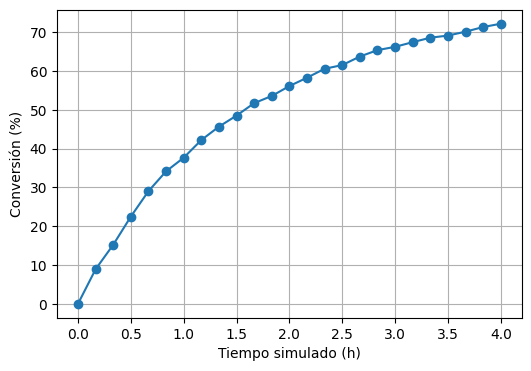

In [27]:
import numpy as np
import itertools
import matplotlib.pyplot as plt


L = LatticeSOS(size=50, seed=42)
L.initialize("flat")

params = KMCParams(
    T=298.15,
    K0_plus=1.0,          # más alto
    E_pb_over_kT=0.45,
    phi_over_kT=2.4,
    delta=1.2,            # más cooperatividad
    V=1.0,
    C_eq=80,              # más bajo para retardar el freno
    S_floor=-5.0,
    S_ceil=8.0
)

kmc = KMC_BKL(lattice=LatticeSOS(50, seed=42),
              params=params,
              N_bulk0=2000,
              rng_seed=123,
              time_scale=60.0)   # más corto


times = np.linspace(0.0, 4.0, 25)
snaps = kmc.run(t_end=4.0, snapshot_times=times)

plt.figure(figsize=(6,4))
plt.plot([t for t,_,_ in snaps], [conv for *_,conv in snaps], marker="o")
plt.xlabel("Tiempo simulado (h)"); plt.ylabel("Conversión (%)"); plt.grid(True); plt.show()


Mejor set: {'K0_plus': 0.2, 'delta': 0.8, 'C_eq': 120, 'rmse': 27.543011817882224}


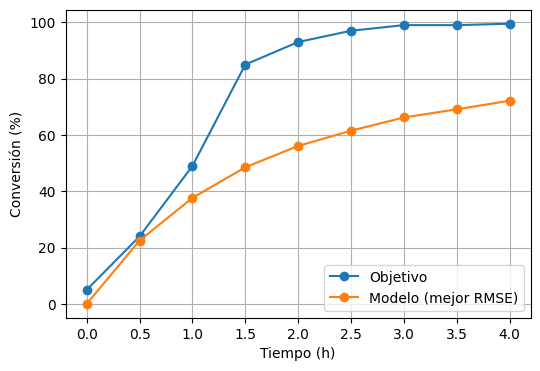

In [29]:
import numpy as np
import itertools
import matplotlib.pyplot as plt


# ---- curva objetivo (edítala con tus datos reales) ----
t_target = np.array([0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0])
y_target = np.array([5,   24,  49,  85,  93,  97,  99,  99,  99.5])

def run_curve(K0_plus, delta, C_eq, N_bulk0=2000, time_scale=100.0, seed=123):
    L = LatticeSOS(size=50, seed=42)
    L.initialize("flat")
    params = KMCParams(
    T=298.15,
    K0_plus=1.0,          # más alto
    E_pb_over_kT=0.45,
    phi_over_kT=2.4,
    delta=1.2,            # más cooperatividad
    V=1.0,
    C_eq=80,              # más bajo para retardar el freno
    S_floor=-5.0,
    S_ceil=8.0
)

    kmc = KMC_BKL(lattice=LatticeSOS(50, seed=42),
              params=params,
              N_bulk0=2000,
              rng_seed=123,
              time_scale=60.0)   # más corto
    snaps = kmc.run(t_end=t_target[-1], snapshot_times=t_target)
    _, _, convs = zip(*snaps)
    return np.array(convs)

def rmse(a,b): 
    d = np.array(a)-np.array(b); 
    return float(np.sqrt(np.mean(d*d)))

# ---- rejilla de búsqueda (ajústala; es rápida) ----
grid_K0   = [0.20, 0.24, 0.28, 0.32]
grid_delta= [0.80, 0.95, 1.10, 1.25]
grid_Ceq  = [120, 160, 200, 260]

best = None
for K0_plus, delta, C_eq in itertools.product(grid_K0, grid_delta, grid_Ceq):
    convs = run_curve(K0_plus, delta, C_eq)
    e = rmse(convs, y_target)
    if (best is None) or (e < best["rmse"]):
        best = {"K0_plus":K0_plus, "delta":delta, "C_eq":C_eq, "rmse":e, "convs":convs}

print("Mejor set:", {k:best[k] for k in ["K0_plus","delta","C_eq","rmse"]})

# ---- ploteo comparativo ----
plt.figure(figsize=(6,4))
plt.plot(t_target, y_target, "o-", label="Objetivo")
plt.plot(t_target, best["convs"], "o-", label="Modelo (mejor RMSE)")
plt.xlabel("Tiempo (h)"); plt.ylabel("Conversión (%)"); plt.grid(True); plt.legend(); plt.show()


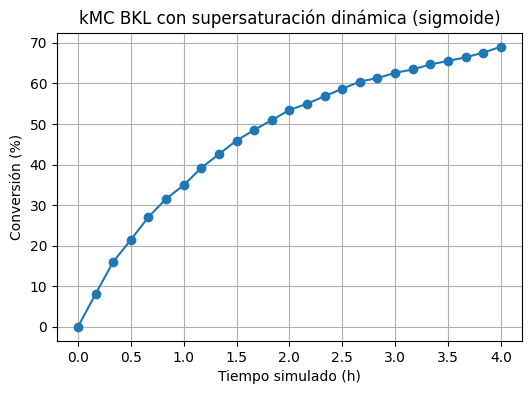

In [24]:
import numpy as np, matplotlib.pyplot as plt

L = LatticeSOS(size=50, seed=42)
L.initialize("flat")

# parámetros que suelen dar S marcada (ajústalos a tus datos)
params = KMCParams(
    T=298.15,
    K0_plus=0.1,
    E_pb_over_kT=0.45,    # ↑ penaliza desorción para i altos, desanima i=0
    phi_over_kT=2.4,
    delta=0.9,            # ↑ hace más fuerte la preferencia por i altos
    V=1.0,
    C_eq=5,             # Ceq > 0 para que S(t)=ln(C/Ceq) decaiga
    S_floor=-5.0,
    S_ceil=8.0
)

kmc = KMC_BKL(lattice=L, params=params, N_bulk0=2500, rng_seed=123, time_scale=100.0)

times = np.linspace(0.0, 4.0, 25)   # 0–4 h
snaps = kmc.run(t_end=4.0, snapshot_times=times)

plt.figure(figsize=(6,4))
plt.plot([t for t,_,_ in snaps], [conv for *_,conv in snaps], marker="o")
plt.xlabel("Tiempo simulado (h)")
plt.ylabel("Conversión (%)")
plt.title("kMC BKL con supersaturación dinámica (sigmoide)")
plt.grid(True)
plt.show()
